0- Architecture of a classification neural network


| **Hyperparameter**                      | **Binary Classification**                                                                                                                                                                                                                                       | **Multiclass classification**                                                                                                                             |
| --------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Input layer shape** (`in_features`)   | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction)                                                                                                                                                    | Same as binary classification                                                                                                                             |
| **Hidden layer(s)**                     | Problem specific, minimum = 1, maximum = unlimited                                                                                                                                                                                                              | Same as binary classification                                                                                                                             |
| **Neurons per hidden layer**            | Problem specific, generally 10 to 512                                                                                                                                                                                                                           | Same as binary classification                                                                                                                             |
| **Output layer shape** (`out_features`) | 1 (one class or the other)                                                                                                                                                                                                                                      | 1 per class (e.g. 3 for food, person or dog photo)                                                                                                        |
| **Hidden layer activation**             | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions)                                    | Same as binary classification                                                                                                                             |
| **Output activation**                   | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)                                                                                                          | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function**                       | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch)                                       | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch)                        |
| **Optimizer**                           | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification                                                                                                                             |


1- Make classification data and get it ready


In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
# See the first 5 of X and y
print(f"First 5 X features:\n{X[:5]}")
print(f"First 5 y features:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y features:
[1 1 1 1 0]


In [3]:
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
    })

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


It looks like each pair of `X` features (`X1` and `X2`) has a label (`y`) value of either 0 or 1.

This tells us that our problem is **binary classification** since there's only two options (0 or 1).

How many values of each class are there?

- By running the line of code below and see 500 each.


In [4]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

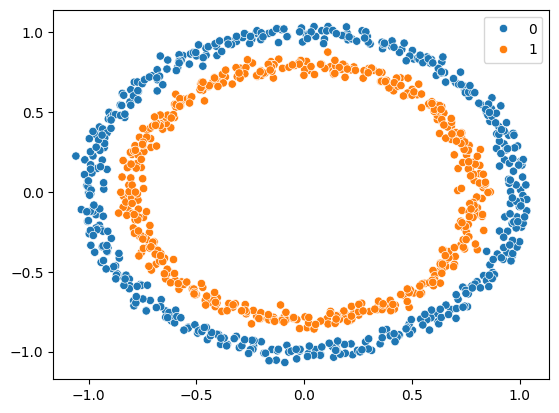

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    data=circles,
    hue=y
);

1.1- Input and output shapes

One of the most common errors in deep learning is shape errors.

Mismatching the shapes of tensors and tensor operations will result in errors in your models.


In [6]:
# Check the shape of features with labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels 
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


👆🏻This tells us the second dimension for X means it has two features (vector) where as y has a single feature (scalar).

We have two inputs for one output.


1.2- Turn data into tensors and create train and test splits


In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on

import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# See!
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split!
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

2- Building a model


In [10]:
# Just import
import torch
from torch import nn

# Make device agnostic code
device = "cpu" if not torch.cuda.is_available() else "cuda"
device

'cpu'

Let's create a model class that:

1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`).
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`.


In [11]:
# Construct a model class that subclass nn.Module 
class CircleModelV0(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # Create 2 nn.Linear layers capable of handling X and y input and output shapes 
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # Defne a forward method containing the forward pass computation 
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y 
        return self.layer_2(self.layer_1(x))
    
# Create an instance of the model and send it to target device 
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# Replicate CircleModelV0 with nn.Sequential 
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Make predictions with the model 
untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 of predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 of test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 of predictions:
tensor([[ 0.1734],
        [-0.0845],
        [ 0.7376],
        [ 0.0140],
        [ 0.5604],
        [ 0.4043],
        [-0.1812],
        [-0.0672],
        [ 0.7442],
        [-0.1037]], grad_fn=<SliceBackward0>)

First 10 of test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


2.1- Setup loss function and optimizer


In [14]:
# Create loss function 
# loss_fn = nn.BCELoss()
# BCELoss = no sigmoid built-in
# BCEWithLogitsLoss = sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer 
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    
    return acc

3- Train the model


3.1- Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)


In [16]:
# View the first 5 outputs of the forward pass on the test data 
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1734],
        [-0.0845],
        [ 0.7376],
        [ 0.0140],
        [ 0.5604]], grad_fn=<SliceBackward0>)

In [17]:
# Use sigmoid on model logits 
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5432],
        [0.4789],
        [0.6765],
        [0.5035],
        [0.6365]], grad_fn=<SigmoidBackward0>)

In [18]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full 
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 0., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

In [19]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

3.2- Building a training and testing loop


In [20]:
torch.manual_seed(42)

# Set the number of epoch 
epochs = 100

# Put data to target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    # Training 
    model_0.train()

    # Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss/accuracy 
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Optimizer zero grad 
    optimizer.zero_grad()

    # Loss backwards 
    loss.backward()

    # Optimizer step 
    optimizer.step()

    # Testing 
    model_0.eval()
    with torch.inference_mode():
        # Forward pass 
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate loss/accuracy 
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs 
    if epoch % 10 ==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72849, Accuracy: 54.00% | Test loss: 0.70869, Test acc: 52.00%
Epoch: 10 | Loss: 0.71532, Accuracy: 51.75% | Test loss: 0.69957, Test acc: 55.00%
Epoch: 20 | Loss: 0.70851, Accuracy: 51.12% | Test loss: 0.69542, Test acc: 52.00%
Epoch: 30 | Loss: 0.70451, Accuracy: 50.75% | Test loss: 0.69337, Test acc: 53.00%
Epoch: 40 | Loss: 0.70189, Accuracy: 50.88% | Test loss: 0.69229, Test acc: 53.50%
Epoch: 50 | Loss: 0.70004, Accuracy: 50.50% | Test loss: 0.69171, Test acc: 53.00%
Epoch: 60 | Loss: 0.69868, Accuracy: 50.62% | Test loss: 0.69142, Test acc: 52.50%
Epoch: 70 | Loss: 0.69764, Accuracy: 50.25% | Test loss: 0.69130, Test acc: 52.50%
Epoch: 80 | Loss: 0.69683, Accuracy: 49.88% | Test loss: 0.69130, Test acc: 52.00%
Epoch: 90 | Loss: 0.69619, Accuracy: 49.62% | Test loss: 0.69137, Test acc: 51.50%


4- Make prediction and evaluate the model


In [21]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print(f"helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


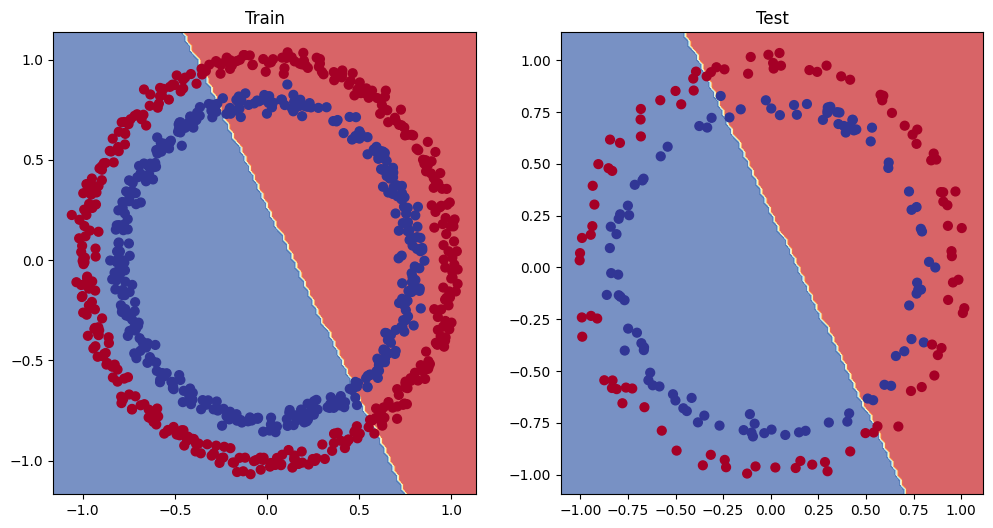

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

5- Improving a model (from a model perspective)


In [23]:
class CircleModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [25]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


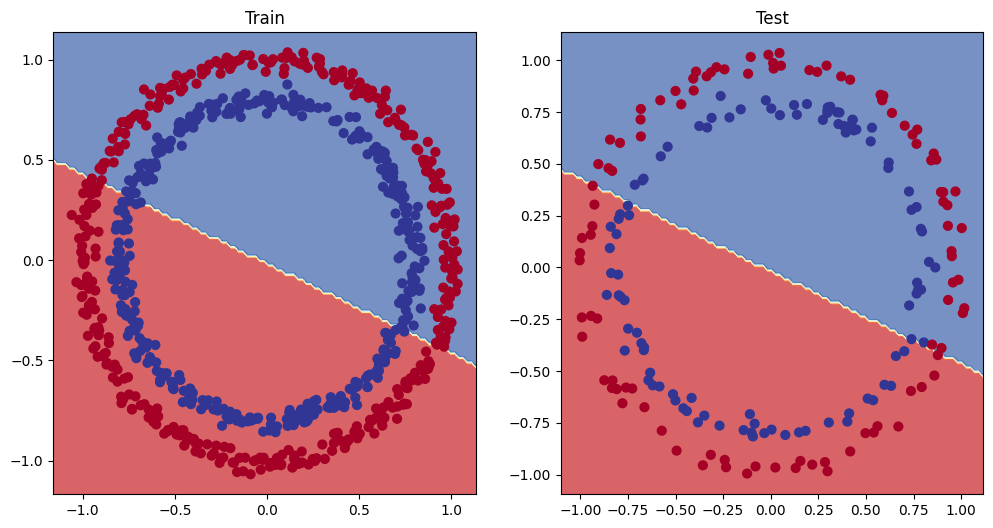

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

5.1- Preparing data to see if our model can model a straight line


In [27]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data 
X_regression = torch.arange(start=start, end=end, step=step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias 

# Check the data 
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [28]:
# Create train and tese split 
train_split = int(.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], X_regression[train_split:]

# Check the length of each split 
print(
    len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression)
)

80 80 20 20


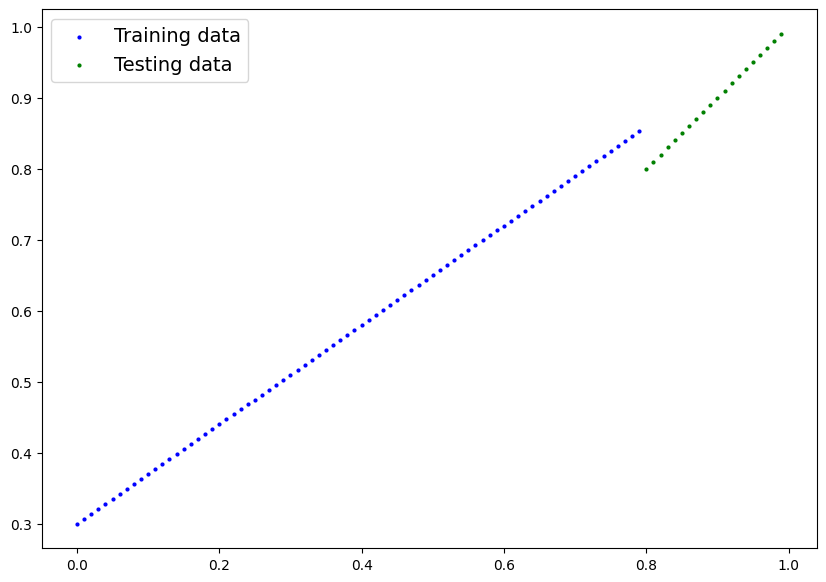

In [29]:
plot_predictions(
    train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

5.2- Adjusting `model_1` to fit a straight line


In [30]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# Loss and optimizer 
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

train the model with epochs of 1000


In [32]:
torch.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 ==0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

    

Epoch: 0 | Train loss: 0.75986, Test loss: 0.50993
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02338
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02335
Epoch: 300 | Train loss: 0.06745, Test loss: 0.03362
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02348
Epoch: 500 | Train loss: 0.05698, Test loss: 0.02678
Epoch: 600 | Train loss: 0.04857, Test loss: 0.04476
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02385
Epoch: 800 | Train loss: 0.05599, Test loss: 0.04576
Epoch: 900 | Train loss: 0.05571, Test loss: 0.03365


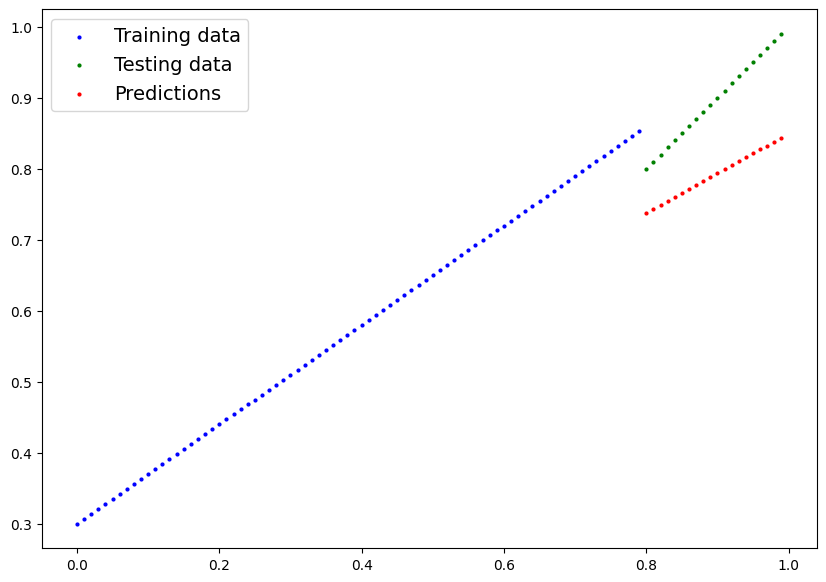

In [33]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression,
    test_labels=y_test_regression,
    predictions=y_preds.cpu()
);

6- The missing piexe: non-linearity


6.1- Recreating non-linear data


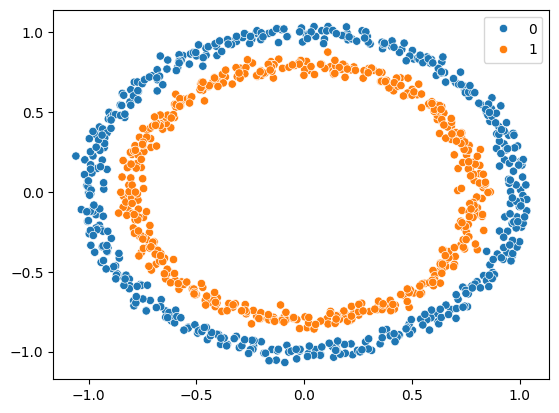

In [34]:
# Make and plot data 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(
    n_samples=n_samples,
    noise=0.03,
    random_state=42
)

sns.scatterplot(x=X[:,0], y=X[:, 1], hue=y)
plt.show()

In [35]:
# Convert to tensor and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=42
)

# See!
X_train[:5], y_train[:5]


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

6.2- Building a model with non-linearity


In [36]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)

print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [37]:
# Set up loss function and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

6.3- Training a model with non-linearity


In [38]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        loss_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.69468, Test Accuracy: 46.00%


6.4- Evaluating a model with train with non-linear activation functions


In [39]:
# Make predictions 
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

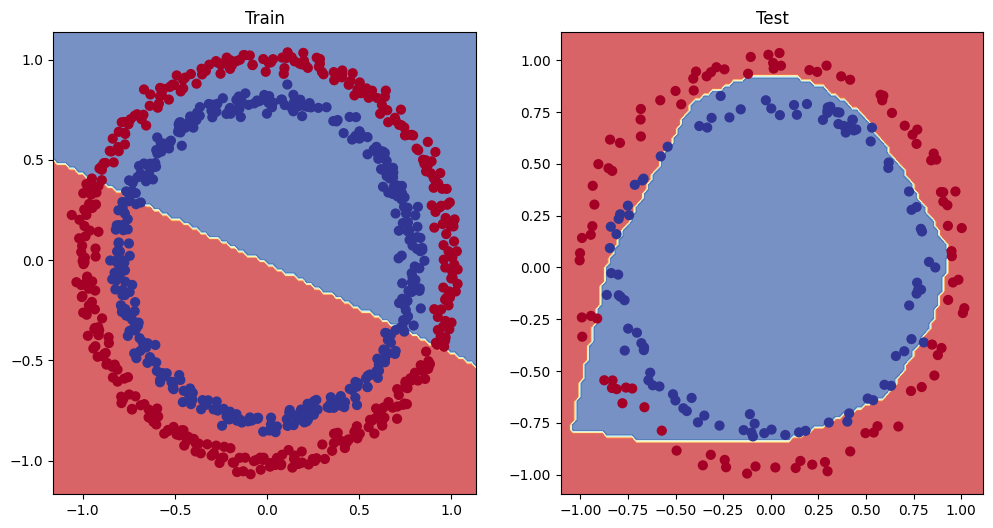

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

7- Replicating non-linear activation functions


In [41]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

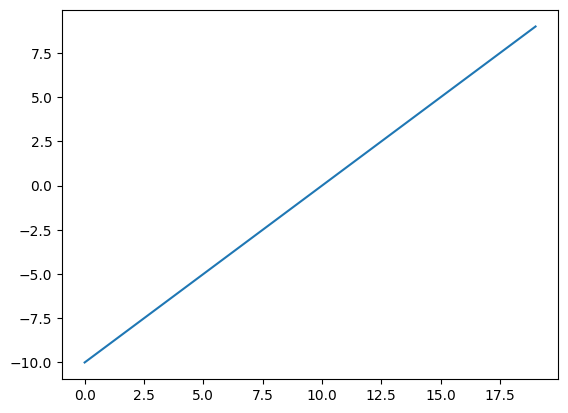

In [42]:
# See!
plt.plot(A)

Now let's see how the ReLU activation function influences it.


In [43]:
# Create ReLU function by hand 
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

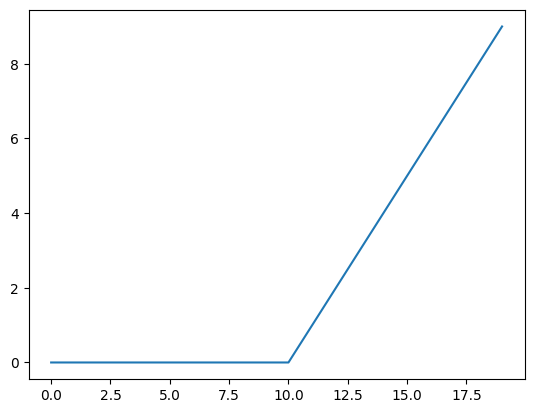

In [45]:
# Plot the ReLU activated toy tensor 
plt.plot(relu(A))
plt.show()

In [46]:
# Create a custom sigmoid function 
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor 
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

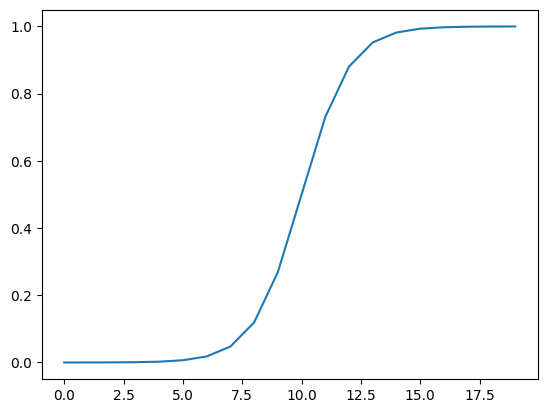

In [47]:
plt.plot(sigmoid(A))
plt.show()

8- Putting things together by building a multi-class PyTorch model


8.1- Creating multi-class classification data


1- Create some multi-class data with make_blobs().

2- Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).

3- Split the data into training and test sets using train_test_split().

4- Visualize the data.


tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


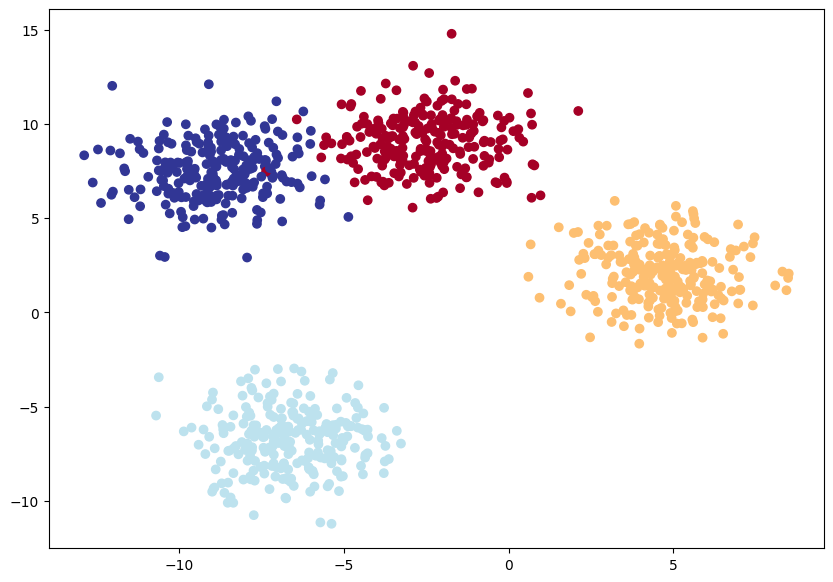

In [61]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);
plt.show()

8.2- Building a multi-class classification model in PyTorch


In [62]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [63]:
from torch import nn

# Build model 
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device 
model_4 = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,
    hidden_units=8
).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

8.3- Creating a loss function and optimizer for a multi-class PyTorch model


In [64]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model_4.parameters(), 
    lr=0.2
) # exercise: try changing the learning rate here and seeing what happens to the model's performance

8.4- Getting prediction probabilities for a multi-class PyTorch model


In [65]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 1.1010,  0.5867, -0.8381,  0.7735],
        [ 0.9743, -3.1038,  0.5808,  2.0448],
        [-1.7637, -0.7465,  2.3091, -1.8137],
        [-0.9728, -1.0193,  1.6660, -0.8549],
        [ 0.6359, -2.8051,  0.7918,  1.5651]], grad_fn=<SliceBackward0>)

In [66]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [67]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 1.1940,  0.2118, -0.7930,  1.0172],
        [ 0.0936, -4.1314,  1.7660,  1.4851],
        [-1.3870, -0.3346,  1.8118, -1.5638],
        [ 0.7131,  0.6526, -0.4988,  0.3292],
        [ 1.3155, -2.4986,  0.0485,  2.1827]], grad_fn=<SliceBackward0>)
tensor([[0.4256, 0.1594, 0.0584, 0.3566],
        [0.0965, 0.0014, 0.5140, 0.3881],
        [0.0342, 0.0981, 0.8390, 0.0287],
        [0.3425, 0.3224, 0.1019, 0.2333],
        [0.2714, 0.0060, 0.0765, 0.6461]], grad_fn=<SliceBackward0>)


In [68]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [69]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.4256, 0.1594, 0.0584, 0.3566], grad_fn=<SelectBackward0>)
tensor(0)


8.5- Creating a training and testing loop for a multi-class PyTorch model


In [70]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(
       y_true=y_blob_train,
       y_pred=y_pred
)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.98100, Acc: 40.88% | Test Loss: 1.39578, Test Acc: 66.00%
Epoch: 10 | Loss: 0.08715, Acc: 99.25% | Test Loss: 0.07245, Test Acc: 99.50%
Epoch: 20 | Loss: 0.05148, Acc: 99.12% | Test Loss: 0.04225, Test Acc: 99.50%
Epoch: 30 | Loss: 0.04104, Acc: 99.12% | Test Loss: 0.03228, Test Acc: 99.50%
Epoch: 40 | Loss: 0.03613, Acc: 99.12% | Test Loss: 0.02731, Test Acc: 99.50%
Epoch: 50 | Loss: 0.03332, Acc: 99.12% | Test Loss: 0.02433, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03153, Acc: 99.12% | Test Loss: 0.02235, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03029, Acc: 99.12% | Test Loss: 0.02093, Test Acc: 99.50%
Epoch: 80 | Loss: 0.02940, Acc: 99.12% | Test Loss: 0.01987, Test Acc: 99.50%
Epoch: 90 | Loss: 0.02872, Acc: 99.12% | Test Loss: 0.01904, Test Acc: 99.50%


8.6- Making and evaluating predictions with a PyTorch multi-class model


In [71]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 7.7852e+00,  1.4700e+01, -1.2499e+01, -8.4589e+00],
        [ 3.6289e+00, -1.5372e+01,  1.6650e+00,  1.0528e+01],
        [-1.2960e+01, -2.0019e+01,  2.0899e+01,  1.0539e+01],
        [ 3.3004e+00,  1.0246e+01, -6.2657e+00, -6.3561e+00],
        [ 1.1883e+01,  6.1699e+00, -1.4122e+01, -2.1061e+00],
        [ 3.8284e+00, -1.9156e+01,  2.6751e+00,  1.3050e+01],
        [-1.2820e+01, -1.5863e+01,  1.9406e+01,  7.8352e+00],
        [ 9.4116e+00,  4.2548e-01, -9.6230e+00,  1.2133e+00],
        [-1.4184e+01, -2.7120e+01,  2.4503e+01,  1.4978e+01],
        [ 1.0122e+01,  2.4899e+00, -1.1049e+01, -1.2286e-02]])

In [72]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


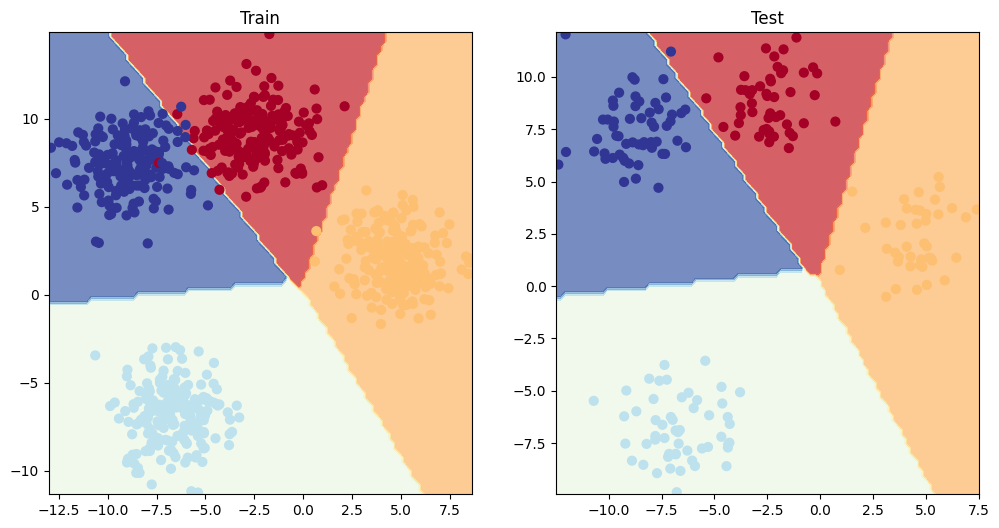

In [73]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

9- More classification evaluation metrics


In [74]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)